# Load and transform training datasets

In [163]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import gc
np.set_printoptions(threshold=50, edgeitems=20)

* Import data
* Transform event_id to string for later encoding

In [164]:
%%time
sys.path.append('../tools')

probs = pd.read_parquet('../data/probs.parquet', engine='pyarrow')
normals = pd.read_parquet('../data/normals.parquet', engine='pyarrow')

probs.event_id = probs.event_id.astype('str')
normals.event_id = normals.event_id.astype('str')

CPU times: user 8.42 s, sys: 1.09 s, total: 9.52 s
Wall time: 9.48 s


Fix identifiers - the same identity can have a regular day and a bad day. We will join the datasets and thus need the IDs to be unique

In [165]:
pident = set(probs.ident.unique())
nident = set(normals.ident.unique())

probs_coding = {}
norms_coding = {}
i = 0
for ident in list(pident): 
    probs_coding[ident] = i
    i += 1

for ident in list(nident):
    norms_coding[ident] = i
    i += 1
    
probs.ident = probs.ident.apply(lambda x: probs_coding[x])
normals.ident = normals.ident.apply(lambda x: norms_coding[x])

In [166]:
ident_class_dict = probs.set_index('ident')['probs'].to_dict()
ident_class_dict.update(normals.set_index('ident')['probs'].to_dict())

## Add device data

In [167]:
%%time
phone_models = pd.read_msgpack('../data/phone_models.msgpack')

device_info = phone_models.loc[:,['TAC', 'seadme_tyyp', 'phone_type']]
device_info.rename(columns={'seadme_tyyp': 'network_type'}, inplace=True)

def add_device_info(df):
    df = df.merge(device_info,how='left', on='TAC')
    df.drop(labels=['TAC'], axis=1, inplace=True)
    return df

normals = add_device_info(normals)
probs = add_device_info(probs)

CPU times: user 3.63 s, sys: 564 ms, total: 4.2 s
Wall time: 4.2 s


## Make DF using one hot encoding

In [168]:
%%time 

cats = ['event_result', 'cause_code', 'sub_cause_code', 'mecontext', 'event_id', 'network_type', 'phone_type']
non_cats = ['ident', 'probs']
def encode_columns(df):
    return pd.concat([df[non_cats], pd.get_dummies(df[cats])], axis=1)
     
df = pd.concat([normals, probs])
df = encode_columns(df)

probs = df.loc[df.probs]
normals = df.loc[~df.probs]

probs.to_parquet('../data/probs_interm.parquet')
normals.to_parquet('../data/norms_interm.parquet')

del df
gc.collect()

CPU times: user 23.6 s, sys: 2.58 s, total: 26.2 s
Wall time: 26.3 s


# Load competition dataset

In [169]:
%%time
sys.path.append('../tools')

test = pd.read_parquet('../data/competition_data.parquet', engine='pyarrow')

test.event_id = test.event_id.astype('str')

CPU times: user 8.82 s, sys: 1.04 s, total: 9.86 s
Wall time: 9.83 s


Add device data to test set

In [170]:
%%time
phone_models = pd.read_msgpack('../data/phone_models.msgpack')

device_info = phone_models.loc[:,['TAC', 'seadme_tyyp', 'phone_type']]
device_info.rename(columns={'seadme_tyyp': 'network_type'}, inplace=True)

def add_device_info(df):
    df = df.merge(device_info,how='left', on='TAC')
    df.drop(labels=['TAC'], axis=1, inplace=True)
    return df

test = add_device_info(test)

CPU times: user 4.65 s, sys: 708 ms, total: 5.36 s
Wall time: 5.36 s


One hot encode the test data

In [171]:
%%time 

cats = ['event_result', 'cause_code', 'sub_cause_code', 'mecontext', 'event_id', 'network_type', 'phone_type']
non_cats = ['ident']
def encode_columns(df):
    return pd.concat([df[non_cats], pd.get_dummies(df[cats])], axis=1)

test = encode_columns(test)

CPU times: user 8.9 s, sys: 1.75 s, total: 10.6 s
Wall time: 10.6 s


In [172]:
test_day = test.groupby('ident').sum()
features = test_day.columns

del test
gc.collect()

213

In [173]:
test_data = test_day.values

In [174]:
features = [x.replace('[', '_') for x in features]
features = [x.replace(']', '_') for x in features]
test_day.columns = features

# Import train data

In [175]:
probs = pd.read_parquet('../data/probs_interm.parquet')
norms = pd.read_parquet('../data/norms_interm.parquet')


In [176]:
probs_day = probs.groupby('ident').sum().drop('probs', axis=1)
norms_day = norms.groupby('ident').sum().drop('probs', axis=1)
feature_names1 = probs_day.columns

del probs, norms
gc.collect()

208

In [177]:
feature_names1 = [x.replace('[', '_') for x in feature_names1]
feature_names1 = [x.replace(']', '_') for x in feature_names1]
probs_day.columns = feature_names1
norms_day.columns = feature_names1

Make sure the training and predictions will have the same feature set

In [178]:
feature_names = [i for i in features if i in feature_names1]

In [179]:
dat = test_day[feature_names].values

In [180]:
dtest = xgb.DMatrix(dat, feature_names=feature_names)

In [181]:
probs_day = probs_day[feature_names]
norms_day = norms_day[feature_names]

In [182]:
from sklearn.model_selection import train_test_split

X_full = np.concatenate([probs_day.values, norms_day.values])
y_full = np.concatenate([probs_day.shape[0] * [1], norms_day.shape[0] * [0]])

del probs_day, norms_day
gc.collect()

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.1)

## Create model

In [183]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from collections import Counter
from operator import itemgetter
import random
import time
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt
import xgboost as xgb

random_state=42
eta = 0.05
max_depth= 6
subsample = 0.5
colsample_bytree = 0.9
min_chil_weight = 5
start_time = time.time()
# scale_pos_weight = class_counts[0] / class_counts[1] 

params = {
    "objective": "binary:logistic",
    "booster" : "gbtree",
    "eval_metric": "auc", #mae
    "eta": eta,
    "gamma": 0.5,
    "max_delta_step": 1.0,
    "tree_method": 'exact',
    "max_depth": max_depth,
    "subsample": subsample,
    "colsample_bytree": colsample_bytree,
    "silent": 1,
    "min_chil_weight":min_chil_weight,
    "seed": random_state,
   # "updater": 'grow_gpu' # Enable this if you have a GPU and compiled XGboost to use it.
}
num_boost_round = 5000
early_stopping_rounds = 40
test_size = 0.2

dtrain = xgb.DMatrix(X_train, y_train, feature_names=feature_names)
dvalid = xgb.DMatrix(X_val, y_val, feature_names=feature_names)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]#[(dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round,
                   evals=watchlist,
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=True)

print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))

[0]	train-auc:0.879357	eval-auc:0.856003
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 40 rounds.
[1]	train-auc:0.927784	eval-auc:0.904422
[2]	train-auc:0.954582	eval-auc:0.936718
[3]	train-auc:0.969012	eval-auc:0.952772
[4]	train-auc:0.973564	eval-auc:0.954643
[5]	train-auc:0.974838	eval-auc:0.962143
[6]	train-auc:0.97921	eval-auc:0.97165
[7]	train-auc:0.984896	eval-auc:0.979983
[8]	train-auc:0.985135	eval-auc:0.979592
[9]	train-auc:0.985598	eval-auc:0.979303
[10]	train-auc:0.985726	eval-auc:0.978997
[11]	train-auc:0.98605	eval-auc:0.979405
[12]	train-auc:0.986234	eval-auc:0.979388
[13]	train-auc:0.986293	eval-auc:0.979405
[14]	train-auc:0.986368	eval-auc:0.979218
[15]	train-auc:0.986388	eval-auc:0.979133
[16]	train-auc:0.986404	eval-auc:0.979201
[17]	train-auc:0.988989	eval-auc:0.980017
[18]	train-auc:0.99005	eval-auc:0.979796
[19]	train-auc:0.992155	eval-auc:0.98
[20]	train-auc:0.992302	eval-auc:0.98

[191]	train-auc:0.999781	eval-auc:0.993095
[192]	train-auc:0.999793	eval-auc:0.992959
[193]	train-auc:0.999798	eval-auc:0.992959
[194]	train-auc:0.999807	eval-auc:0.992891
[195]	train-auc:0.999808	eval-auc:0.992857
[196]	train-auc:0.99981	eval-auc:0.992959
[197]	train-auc:0.999814	eval-auc:0.992891
[198]	train-auc:0.999813	eval-auc:0.992891
[199]	train-auc:0.999817	eval-auc:0.992789
[200]	train-auc:0.999815	eval-auc:0.992687
[201]	train-auc:0.999817	eval-auc:0.992619
[202]	train-auc:0.999812	eval-auc:0.992653
[203]	train-auc:0.999821	eval-auc:0.992585
[204]	train-auc:0.999823	eval-auc:0.992585
[205]	train-auc:0.999829	eval-auc:0.992585
[206]	train-auc:0.999835	eval-auc:0.992517
[207]	train-auc:0.999833	eval-auc:0.992551
[208]	train-auc:0.999837	eval-auc:0.992517
[209]	train-auc:0.999843	eval-auc:0.992551
[210]	train-auc:0.999843	eval-auc:0.992619
Stopping. Best iteration:
[170]	train-auc:0.999631	eval-auc:0.993435

Training time: 0.03 minutes


## Hyperparameter tuning - can be skipped

In [184]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)

cv_results

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.860933,0.034475,0.889736,0.009114
1,0.914560,0.020634,0.932293,0.017534
2,0.944372,0.024559,0.952187,0.015166
3,0.956765,0.016842,0.968047,0.008107
4,0.964787,0.009651,0.976567,0.005196
5,0.965487,0.009191,0.977485,0.004555
6,0.968746,0.005875,0.978058,0.004303
7,0.971081,0.006828,0.982087,0.003850
8,0.974234,0.004336,0.983786,0.001583
9,0.974757,0.004187,0.984643,0.001800


In [185]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10)
    for min_child_weight in range(3,7)
]

In [186]:
# Define initial best params and MAE
max_auc = 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print(f"CV with max_depth={max_depth}, min_child_weight={min_child_weight}")

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )

    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print(f"\tAUC {mean_auc} for {boost_rounds} rounds")
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)

print(f"Best params: {best_params[0]}, {best_params[1]}, AUC: {max_auc}")

CV with max_depth=3, min_child_weight=3
	AUC 0.9858696 for 32 rounds
CV with max_depth=3, min_child_weight=4
	AUC 0.9872690000000001 for 68 rounds
CV with max_depth=3, min_child_weight=5
	AUC 0.9858296 for 31 rounds
CV with max_depth=3, min_child_weight=6
	AUC 0.9856696000000001 for 36 rounds
CV with max_depth=4, min_child_weight=3
	AUC 0.9861902 for 39 rounds
CV with max_depth=4, min_child_weight=4
	AUC 0.9876678 for 59 rounds
CV with max_depth=4, min_child_weight=5
	AUC 0.9877324 for 60 rounds
CV with max_depth=4, min_child_weight=6
	AUC 0.9873036000000001 for 59 rounds
CV with max_depth=5, min_child_weight=3
	AUC 0.9877166 for 65 rounds
CV with max_depth=5, min_child_weight=4
	AUC 0.9875766 for 51 rounds
CV with max_depth=5, min_child_weight=5
	AUC 0.9876813999999999 for 59 rounds
CV with max_depth=5, min_child_weight=6
	AUC 0.9875475999999999 for 66 rounds
CV with max_depth=6, min_child_weight=3
	AUC 0.9876606000000001 for 60 rounds
CV with max_depth=6, min_child_weight=4
	AUC 0.98

In [187]:
params['max_depth'] = 7
params['min_child_weight'] = 5

In [188]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(3,6)]
    for colsample in [i/10. for i in range(7,11)]
]

In [189]:
max_auc = 0
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print(f"CV with subsample={subsample}, colsample={colsample}")

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )

    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print(f"\tAUC {mean_auc} for {boost_rounds} rounds")
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample)

print(f"Best params: {best_params[0]}, {best_params[1]}, AUC: {max_auc}")

CV with subsample=0.5, colsample=1.0
	AUC 0.9879128000000001 for 59 rounds
CV with subsample=0.5, colsample=0.9
	AUC 0.9877524000000001 for 60 rounds
CV with subsample=0.5, colsample=0.8
	AUC 0.9876954 for 78 rounds
CV with subsample=0.5, colsample=0.7
	AUC 0.9876590000000001 for 65 rounds
CV with subsample=0.4, colsample=1.0
	AUC 0.9869792000000001 for 64 rounds
CV with subsample=0.4, colsample=0.9
	AUC 0.9870505999999999 for 67 rounds
CV with subsample=0.4, colsample=0.8
	AUC 0.9875352 for 90 rounds
CV with subsample=0.4, colsample=0.7
	AUC 0.987364 for 61 rounds
CV with subsample=0.3, colsample=1.0
	AUC 0.9872946 for 59 rounds
CV with subsample=0.3, colsample=0.9
	AUC 0.9873876000000001 for 87 rounds
CV with subsample=0.3, colsample=0.8
	AUC 0.9874938 for 87 rounds
CV with subsample=0.3, colsample=0.7
	AUC 0.9870986 for 79 rounds
Best params: 0.5, 1.0, AUC: 0.9879128000000001


In [190]:
params['subsample'] = .5
params['colsample_bytree'] = 1.

In [191]:
max_auc = 0
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print(f"CV with eta={eta}")

    # We update our parameters
    params['eta'] = eta

    # Run and time CV
    %time 
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['auc'],
        early_stopping_rounds=10)

    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print(f"\tAUC {mean_auc} for {boost_rounds} rounds\n")
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta

print(f"Best params: {best_params}, AUC: {max_auc}")

CV with eta=0.3
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs
	AUC 0.9869388000000001 for 31 rounds

CV with eta=0.2
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
	AUC 0.9877075999999999 for 31 rounds

CV with eta=0.1
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs
	AUC 0.9875617999999999 for 30 rounds

CV with eta=0.05
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs
	AUC 0.9879128000000001 for 59 rounds

CV with eta=0.01
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs
	AUC 0.9864564 for 188 rounds

CV with eta=0.005
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs
	AUC 0.9693278 for 34 rounds

Best params: 0.05, AUC: 0.9879128000000001


In [192]:
params['eta'] = .05

In [193]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, 'train'), (dvalid, 'eval')],
    early_stopping_rounds=10
)

[0]	train-auc:0.886619	eval-auc:0.856003
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.919411	eval-auc:0.920765
[2]	train-auc:0.945406	eval-auc:0.945748
[3]	train-auc:0.954623	eval-auc:0.954354
[4]	train-auc:0.959605	eval-auc:0.961837
[5]	train-auc:0.959813	eval-auc:0.961633
[6]	train-auc:0.969367	eval-auc:0.961173
[7]	train-auc:0.972046	eval-auc:0.969286
[8]	train-auc:0.973603	eval-auc:0.969201
[9]	train-auc:0.973679	eval-auc:0.969235
[10]	train-auc:0.973873	eval-auc:0.969558
[11]	train-auc:0.974828	eval-auc:0.968997
[12]	train-auc:0.974948	eval-auc:0.969201
[13]	train-auc:0.97621	eval-auc:0.969201
[14]	train-auc:0.976157	eval-auc:0.969337
[15]	train-auc:0.97627	eval-auc:0.96966
[16]	train-auc:0.978796	eval-auc:0.978248
[17]	train-auc:0.983582	eval-auc:0.98631
[18]	train-auc:0.987119	eval-auc:0.986752
[19]	train-auc:0.987278	eval-auc:0.986514
[20]	train-auc:0.987374	eval-auc:

In [194]:
print(f"Best AUC: {model.best_score:.2f} in {model.best_iteration+1} rounds")

Best AUC: 0.99 in 70 rounds


In [195]:
num_boost_round = model.best_iteration + 1

best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, 'train'), (dvalid, 'eval')]
)

[0]	train-auc:0.886619	eval-auc:0.856003
[1]	train-auc:0.919411	eval-auc:0.920765
[2]	train-auc:0.945406	eval-auc:0.945748
[3]	train-auc:0.954623	eval-auc:0.954354
[4]	train-auc:0.959605	eval-auc:0.961837
[5]	train-auc:0.959813	eval-auc:0.961633
[6]	train-auc:0.969367	eval-auc:0.961173
[7]	train-auc:0.972046	eval-auc:0.969286
[8]	train-auc:0.973603	eval-auc:0.969201
[9]	train-auc:0.973679	eval-auc:0.969235
[10]	train-auc:0.973873	eval-auc:0.969558
[11]	train-auc:0.974828	eval-auc:0.968997
[12]	train-auc:0.974948	eval-auc:0.969201
[13]	train-auc:0.97621	eval-auc:0.969201
[14]	train-auc:0.976157	eval-auc:0.969337
[15]	train-auc:0.97627	eval-auc:0.96966
[16]	train-auc:0.978796	eval-auc:0.978248
[17]	train-auc:0.983582	eval-auc:0.98631
[18]	train-auc:0.987119	eval-auc:0.986752
[19]	train-auc:0.987278	eval-auc:0.986514
[20]	train-auc:0.987374	eval-auc:0.98699
[21]	train-auc:0.98764	eval-auc:0.987364
[22]	train-auc:0.98765	eval-auc:0.987024
[23]	train-auc:0.98801	eval-auc:0.987296
[24]	train

In [196]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)

cv_results

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.874222,0.028236,0.890984,0.013493
1,0.913018,0.029364,0.922955,0.014769
2,0.937284,0.015120,0.941140,0.014277
3,0.947618,0.015770,0.955583,0.008713
4,0.962514,0.003618,0.963954,0.007594
5,0.964672,0.002675,0.965032,0.007793
6,0.965847,0.001731,0.969937,0.005765
7,0.973551,0.006814,0.975735,0.003733
8,0.974611,0.006150,0.977072,0.002954
9,0.977108,0.004627,0.978620,0.003872


## Save / Load model

In [197]:
best_model.save_model("my_model.model")

In [198]:
loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model")

## Predict

Validating...
area under the precision-recall curve: 0.937552
precision score: 0.910714
recall score: 0.850000
accuracy score: 0.974545


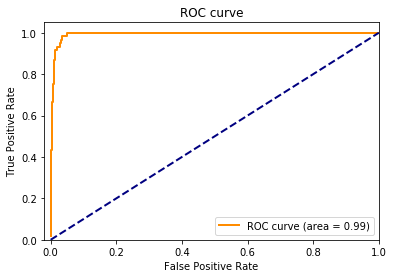

In [199]:
from sklearn.metrics import accuracy_score
print("Validating...")
check = gbm.predict(xgb.DMatrix(X_val, feature_names=feature_names), ntree_limit=gbm.best_iteration+1)

#area under the precision-recall curve
score = average_precision_score(y_val, check)
print(f'area under the precision-recall curve: {score:.6f}')

check2=check.round()
score = precision_score(y_val, check2)
print(f'precision score: {score:.6f}')

score = recall_score(y_val, check2)
print(f'recall score: {score:.6f}')

score = accuracy_score(y_val, check2)
print(f'accuracy score: {score:.6f}')

fpr, tpr, _ = roc_curve(y_val, check)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

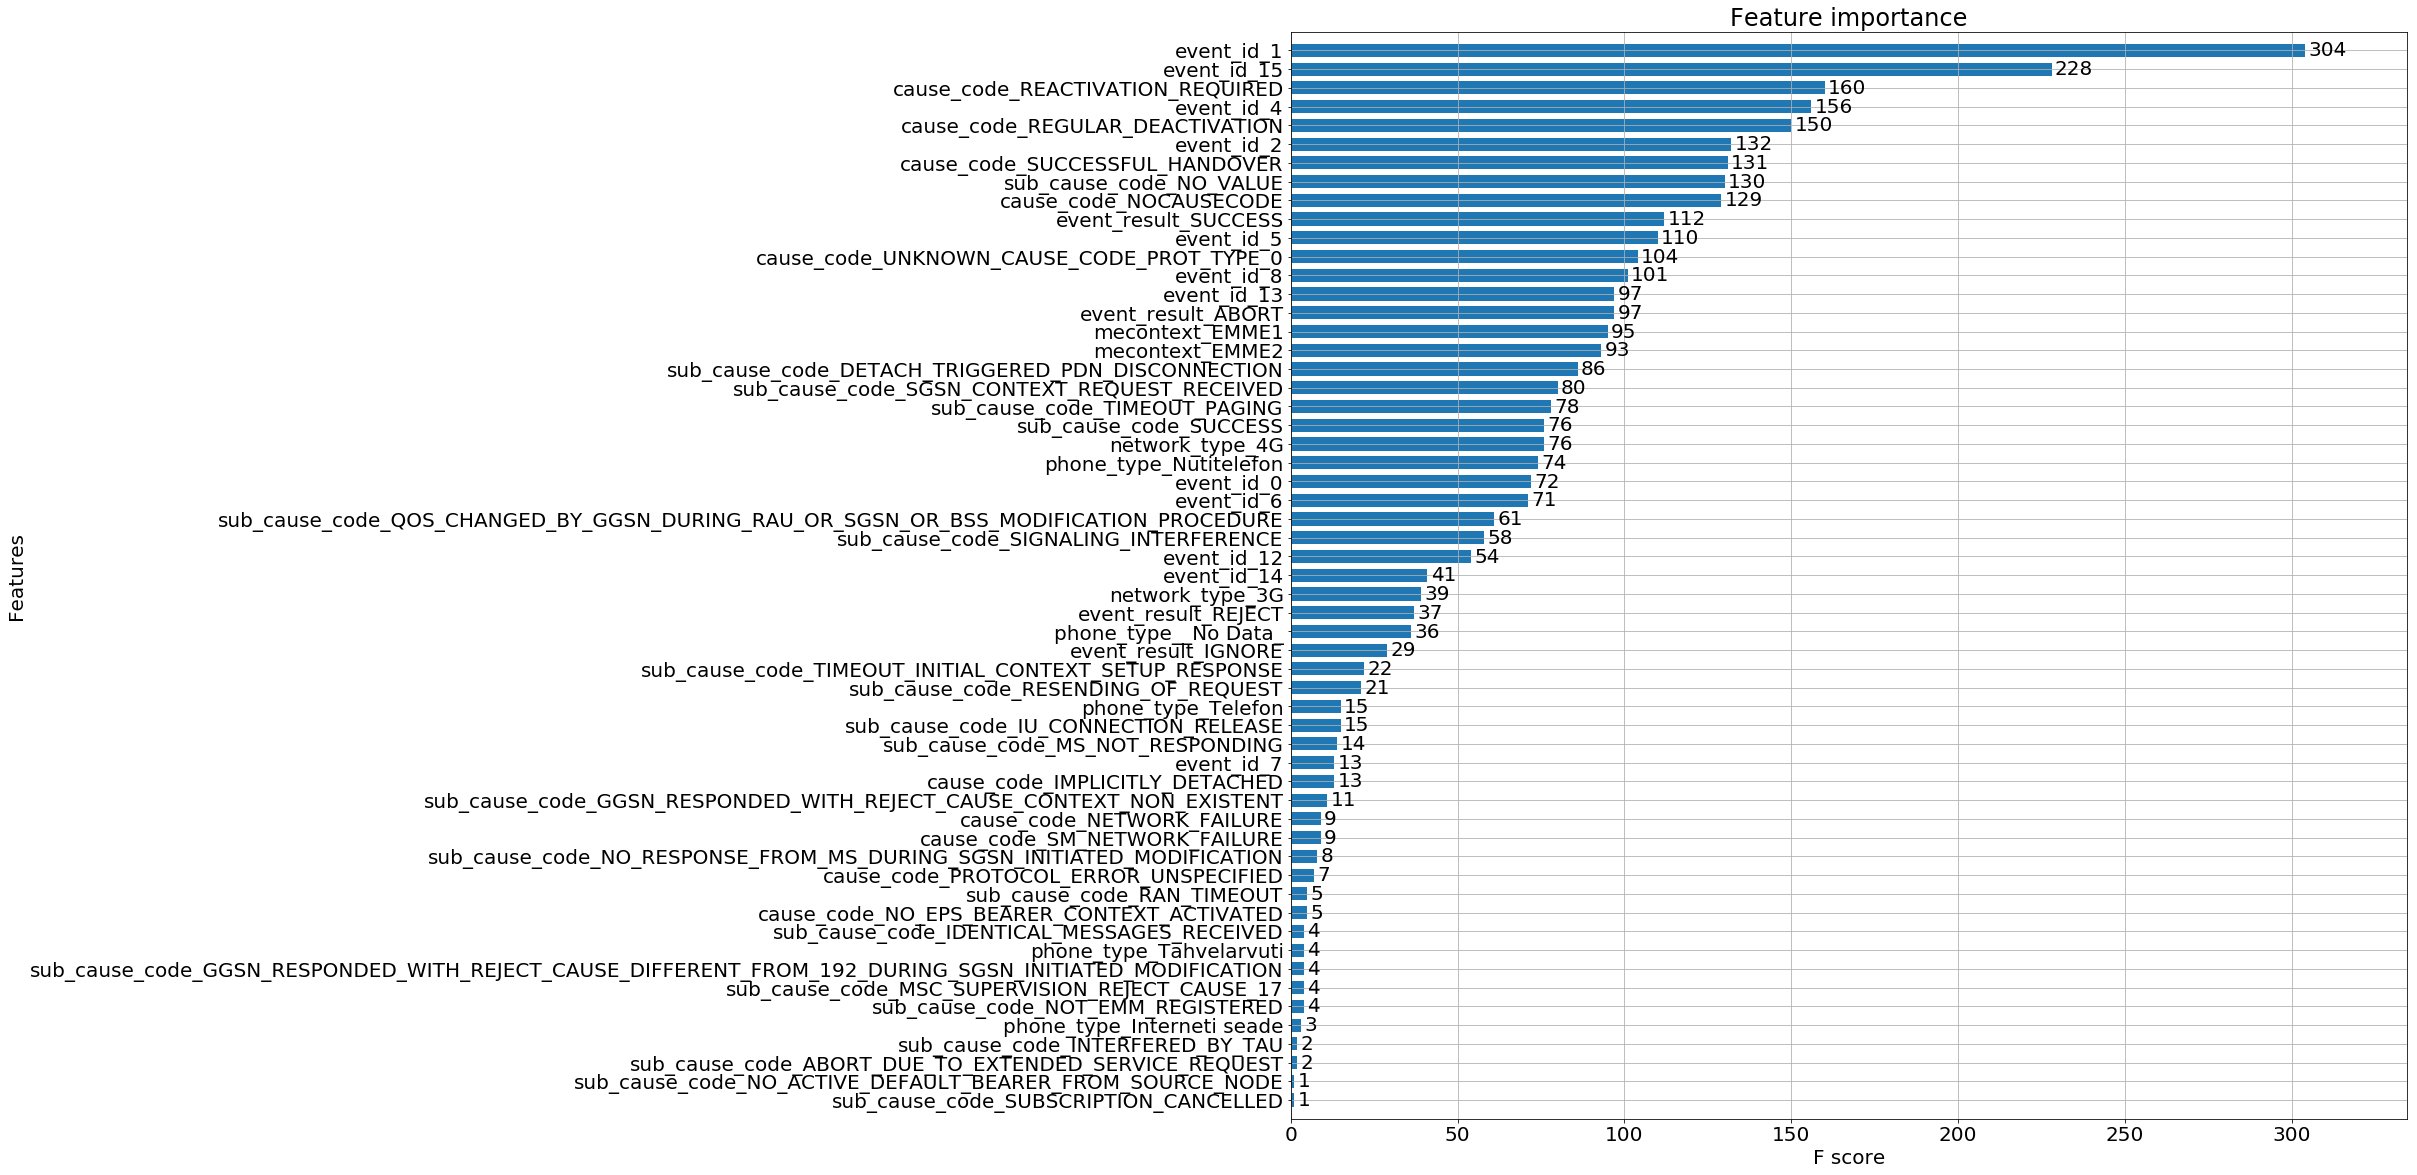

In [200]:
import matplotlib
import matplotlib.pyplot as plt
from xgboost import plot_importance
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=[20,20])
plot_importance(gbm, ax=plt.gca(), height=0.7, max_num_features=200)

## Formatting results

In [201]:
results = loaded_model.predict(dtest)

In [202]:
result = pd.DataFrame({'customerID':test_day.index, 'prediction':results})

### Labelling the competition results and saving the output

In [203]:
result['label'] = result['prediction']>=0.5

In [204]:
result.head(10)

,customerID,prediction,label
0,0,0.029312,False
1,1,0.040873,False
2,2,0.833100,True
3,3,0.029384,False
4,4,0.029384,False
5,5,0.029312,False
6,6,0.029312,False
7,7,0.029312,False
8,8,0.029312,False
9,9,0.029312,False


In [205]:
result.drop('prediction', axis=1).to_csv('../submission.csv', index=False, header=False, sep = ';')